In [197]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [198]:
# Load data

In [199]:
# path config
df_products = pd.read_csv('products.csv')
df_ratings =pd.read_csv('ratings.csv')

In [200]:
df_products.head()

,productId,products,category
0,1,Iphone 13 Pro Max,flagship
1,2,Iphone 13 Pro,high_end
2,3,Iphone 13,high_end
3,4,Iphone 13 Mini,high_end
4,5,Iphone 12 Pro Max,high_end


In [201]:
df_ratings.head()

,userId,productId,rating,timestamp
0,1,7,3,964982931.0
1,2,30,3,964982176.0
2,3,51,5,964984002.0
3,4,28,2,964982681.0
4,5,44,5,964984041.0


In [202]:
# Exploratory data analysis

In [203]:
# Get the counts of each rating per phone 
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
1,209
2,195
3,207
4,176
5,213


Text(0, 0.5, 'number of ratings')

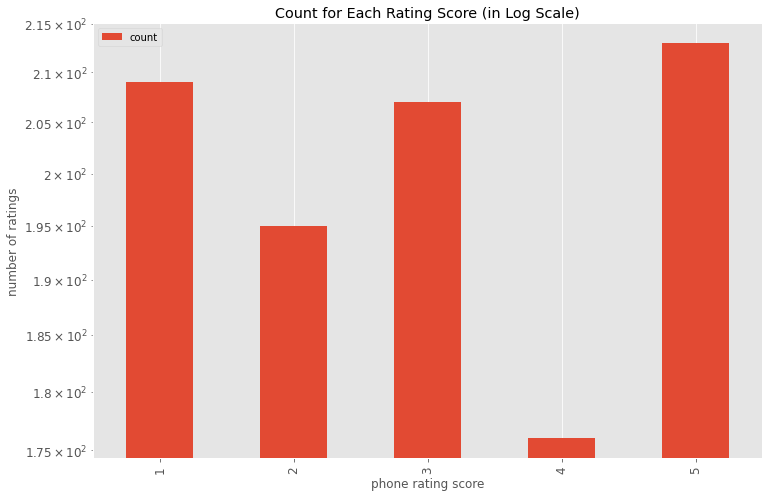

In [204]:
ax = df_ratings_cnt_tmp[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("phone rating score")
ax.set_ylabel("number of ratings")

In [205]:
#df_products.drop(['category'], axis=1)
df_products_with_counts = pd.merge(df_products,df_products_cnt, suffixes=['_left', '_right'], left_on='productId',right_on='productId')
df_products_with_counts

,productId,products,category,count
0,1,Iphone 13 Pro Max,flagship,14
1,2,Iphone 13 Pro,high_end,20
2,3,Iphone 13,high_end,9
3,4,Iphone 13 Mini,high_end,20
4,5,Iphone 12 Pro Max,high_end,14
5,6,Iphone 12 Pro,high_end,18
6,7,Iphone 12,high_end,14
7,8,Iphone 12 Mini,high_end,23
8,9,Iphone 11 Pro Max,mid_range,16
9,10,Iphone 11 Pro,mid_range,22


In [206]:
df_products_with_counts=df_products_with_counts.drop('productId',axis=1,inplace=False)
df_products_with_counts

,products,category,count
0,Iphone 13 Pro Max,flagship,14
1,Iphone 13 Pro,high_end,20
2,Iphone 13,high_end,9
3,Iphone 13 Mini,high_end,20
4,Iphone 12 Pro Max,high_end,14
5,Iphone 12 Pro,high_end,18
6,Iphone 12,high_end,14
7,Iphone 12 Mini,high_end,23
8,Iphone 11 Pro Max,mid_range,16
9,Iphone 11 Pro,mid_range,22


In [207]:
df_products_with_counts=df_products_with_counts.drop('category', axis=1,inplace=False)
df_products_with_counts

,products,count
0,Iphone 13 Pro Max,14
1,Iphone 13 Pro,20
2,Iphone 13,9
3,Iphone 13 Mini,20
4,Iphone 12 Pro Max,14
5,Iphone 12 Pro,18
6,Iphone 12,14
7,Iphone 12 Mini,23
8,Iphone 11 Pro Max,16
9,Iphone 11 Pro,22


In [227]:
# get rating frequency
#df_products_cnt = pd.DataFrame(df_ratings.groupby('productId').size(), columns=['count'])
#df_products_cnt #emfanizei ton pinaka me vasi pio proion exei poses aksiologiseis


In [229]:
#plot rating frequency of all products
ax = df_products_with_counts[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='products' ,
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,        
)
df_products_with_counts
ax.set_xlabel("products")
ax.set_ylabel("number of ratings")

KeyError: 'products'